# Mixture of Experts Forecasting Models

In this notebook all relevant Mixture of Experts models (gating: soft, top_1, top_k) are build, compiled, fitted, evaluated, plotted, and tuned. Therefore, the notebook ist structured into: 
- Data Handling
- Model Building

In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf
from keras import layers, models

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

### Data Handling
- **Get Data**: Load data to dataframe from User5. Data includes Date, temp, hour and Electricity consumption
- **Train, Validation and Test datasets**: Split Data into train, validation and test datasets
- **Normalize Data**: Normalize each feature of the the different datasets
- **Sequencing**: Take the 3 datasets and split them into sequences of length=sequence_length, then split the sequence into  X (features) and Y (labels)

In [2]:
#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

#Select only 1 User for testing
df = df[['User12', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', 'User2_lag_24hrs']]
df.head(3)

,User12,temp,rhum,wspd,PC1,hour sin,hour cos,User2_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.152,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.102
2012-07-08 01:00:00,0.212,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.116
2012-07-08 02:00:00,0.218,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.133


In [3]:
#Train, Validation and Test datasets
sequence_length = 25
batch_size = 16
num_features = df.shape[1]

dh = Datahandler()

#Create Train, Validation and Test datasets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Min max sclaing
train_df = dh.min_max_scaling(train_df)
val_df = dh.min_max_scaling(val_df)
test_df = dh.min_max_scaling(test_df)

# Sequencing
train_sequences = dh.create_sequences(train_df, sequence_length)
val_sequences = dh.create_sequences(val_df, sequence_length)
test_sequences = dh.create_sequences(test_df, sequence_length)

#Split into feature and label
X_train, y_train = dh.prepare_data(train_sequences, batch_size)
X_val, y_val = dh.prepare_data(val_sequences, batch_size)
X_test, y_test = dh.prepare_data(test_sequences, batch_size)

### Model Building
Build and test different model architecture

In [4]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
callbacks=[early_stopping, timing_callback, custom_callback]

Evaluation round:  1
Loss:  [0.015337790362536907, 0.12384583055973053, 187941.6875, 0.09478640556335449]
Evaluation round:  2
Loss:  [0.01646364852786064, 0.12831075489521027, 192804.53125, 0.09826857596635818]
Evaluation round:  3
Loss:  [0.013324386440217495, 0.11543130874633789, 111306.0703125, 0.0755312517285347]
Evaluation round:  4
Loss:  [0.011777604930102825, 0.10852467268705368, 115099.625, 0.06618905812501907]
Evaluation round:  5
Loss:  [0.013970939442515373, 0.11819873005151749, 193639.734375, 0.09524112194776535]


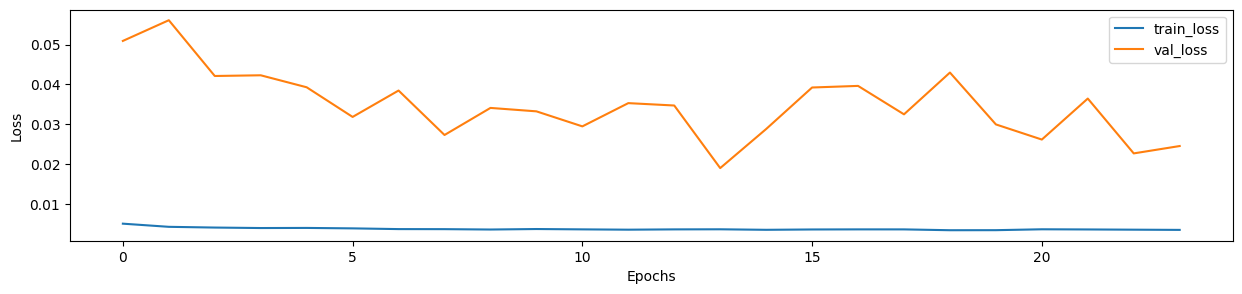

52/52 [==============================] - 0s 747us/step


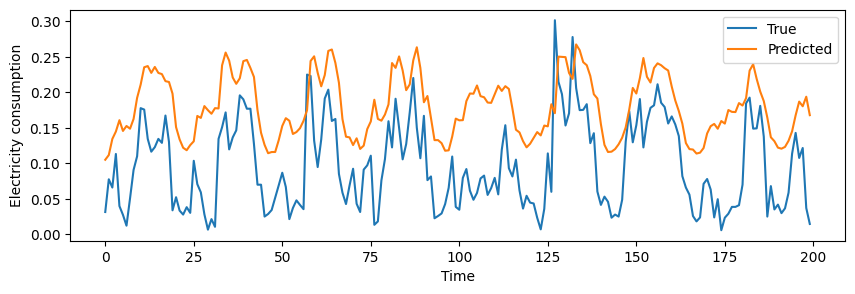

In [7]:
#Soft Dense MoE Model
soft_dense_moe_results = pd.DataFrame(columns=['avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])

tuning_rounds = 5

num_experts = 10 # 3-5
sequenze_length = 24
expert_capacity = sequenze_length*batch_size // num_experts #= 48 / 10 = 4

dense_1_units = 4
expert_hidden_units = 4
expert_output_units = 4
dense_2_units = 4

for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    soft_dense_moe_model = m1.build_soft_dense_moe_model(X_train, batch_size, horizon, dense_1_units, num_experts, expert_hidden_units, expert_output_units, dense_2_units, m1)
    soft_dense_moe_model_history, soft_dense_moe_results, soft_dense_moe_summary  = mh.compile_fit_evaluate_model(soft_dense_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
    soft_dense_moe_results = pd.concat([soft_dense_moe_results, soft_dense_moe_summary])

mh.plot_model_predictions(soft_dense_moe_model, soft_dense_moe_model_history, y_test, X_test, batch_size)

Evaluation round:  1
Loss:  [0.014545891433954239, 0.12060634791851044, 146053.359375, 0.09088537096977234]
Evaluation round:  2
Loss:  [0.01412421278655529, 0.11884532868862152, 128121.6953125, 0.0791519433259964]
Evaluation round:  3
Loss:  [0.013356562703847885, 0.11557059735059738, 178316.53125, 0.09274905174970627]
Evaluation round:  4
Loss:  [0.014165620319545269, 0.11901941150426865, 156598.203125, 0.08610638976097107]
Evaluation round:  5
Loss:  [0.011492880061268806, 0.1072048544883728, 130698.640625, 0.07604154199361801]


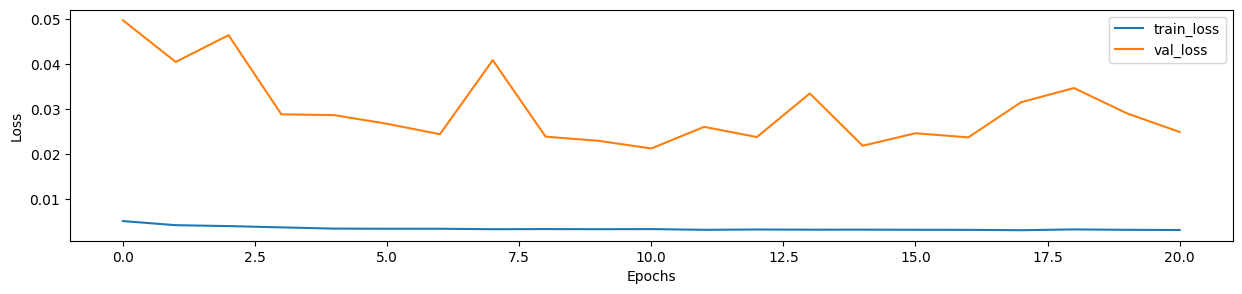

52/52 [==============================] - 1s 2ms/step


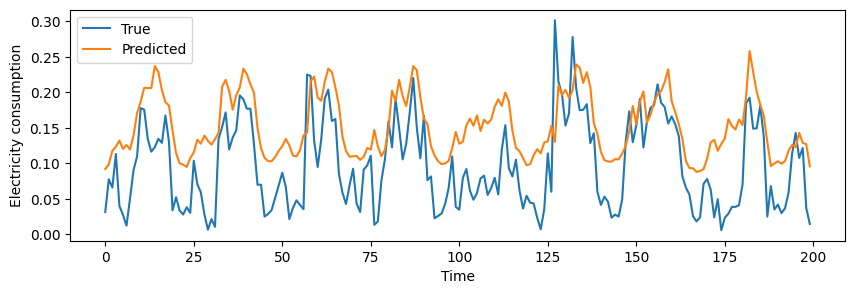

In [9]:
#Soft BiLSTM MoE Model
soft_bilstm_moe_results = pd.DataFrame(columns=['avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])

tuning_rounds = 5

num_experts = 10 # 3-5
sequenze_length = 24
expert_capacity = sequenze_length*batch_size // num_experts #= 48 / 10 = 4

dense_1_units = 4
expert_hidden_units = 4
expert_output_units = 4
dense_2_units = 4

for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    soft_bilstm_moe_model = m1.build_soft_biLSTM_moe_model(X_train, batch_size, horizon, dense_1_units, num_experts, expert_hidden_units, expert_output_units, dense_2_units, m1)
    soft_bilstm_moe_model_history, soft_bilstm_moe_results, soft_bilstm_moe_summary  = mh.compile_fit_evaluate_model(soft_bilstm_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
    soft_bilstm_moe_results = pd.concat([soft_bilstm_moe_results, soft_bilstm_moe_summary])

mh.plot_model_predictions(soft_bilstm_moe_model, soft_bilstm_moe_model_history, y_test, X_test, batch_size)

Evaluation round:  1
Loss:  [0.015086309984326363, 0.12282633781433105, 177508.21875, 0.09658384323120117]
Evaluation round:  2
Loss:  [0.011493618600070477, 0.10720829665660858, 153517.890625, 0.077879399061203]
Evaluation round:  3
Loss:  [0.013576528057456017, 0.11651835590600967, 180757.328125, 0.0896546021103859]
Evaluation round:  4
Loss:  [0.017294812947511673, 0.13150975108146667, 185094.21875, 0.0965348407626152]
Evaluation round:  5
Loss:  [0.014746572822332382, 0.12143547087907791, 142621.359375, 0.0813332349061966]


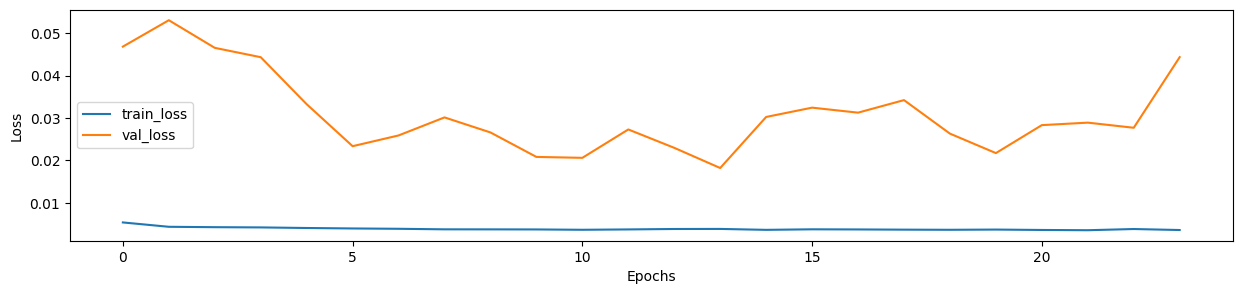

52/52 [==============================] - 0s 729us/step


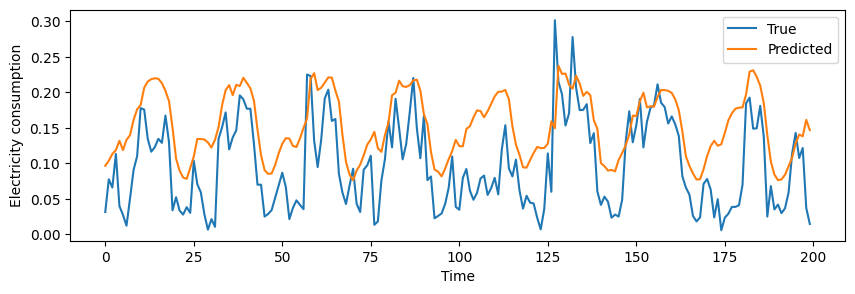

In [7]:
#topk Dense MoE Model
topk_dense_moe_results =  pd.DataFrame(columns=['avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])

tuning_rounds = 5
#MoE
num_experts = 5 # 5! or 10
top_k = 3 #1 or 3!
biLSTM_1_units = 4
expert_hidden_units = 8
dense_2_units = 2


for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    topk_dense_moe_model = m1.build_topk_dense_moe_model(X_train, batch_size, horizon, biLSTM_1_units, num_experts, top_k, expert_hidden_units, dense_2_units, m1)
    topk_dense_moe_model_history, topk_dense_moe_results, topk_dense_moe_summary  = mh.compile_fit_evaluate_model(topk_dense_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
    topk_dense_moe_results = pd.concat([topk_dense_moe_results, topk_dense_moe_summary])

mh.plot_model_predictions(topk_dense_moe_model, topk_dense_moe_model_history, y_test, X_test, batch_size)

Evaluation round:  1
Loss:  [0.012984746135771275, 0.11395063251256943, 155030.8125, 0.07283805310726166]
Evaluation round:  2
Loss:  [0.011865238659083843, 0.10892767459154129, 136013.109375, 0.07508151233196259]
Evaluation round:  3
Loss:  [0.013560174033045769, 0.11644816398620605, 165769.09375, 0.07845532149076462]
Evaluation round:  4
Loss:  [0.009945050813257694, 0.09972487390041351, 113887.4453125, 0.06682310253381729]
Evaluation round:  5
Loss:  [0.014212766662240028, 0.11921730637550354, 153763.859375, 0.0803169533610344]


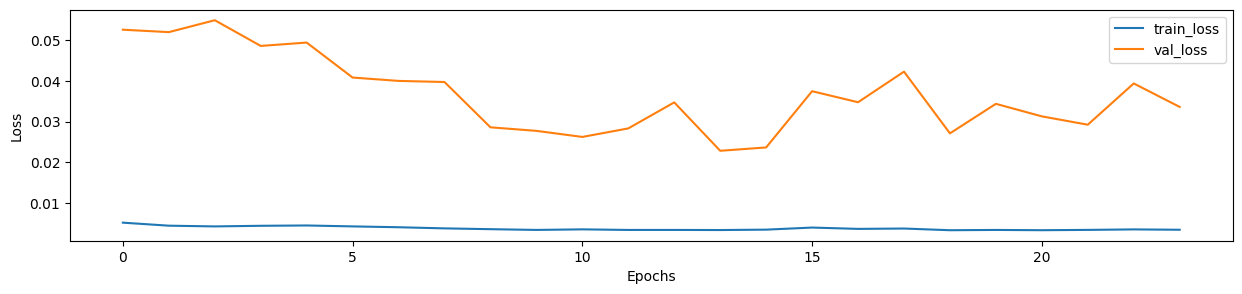

52/52 [==============================] - 0s 2ms/step


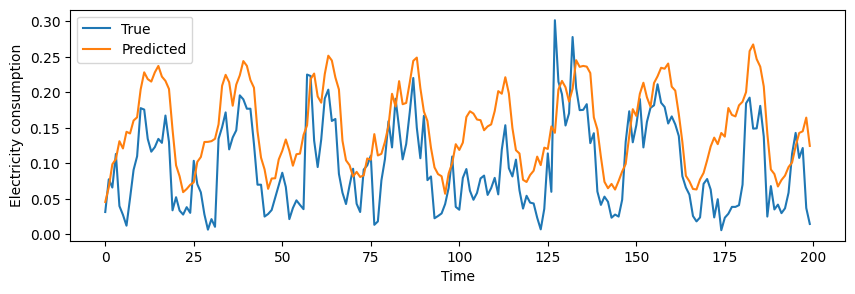

In [8]:
#topk BiLSTM MoE Model
topk_moe_results =  pd.DataFrame(columns=['avg_num_eppochs', 'avg_train_time_epoch', 'avg_total_train_time', 'avg_test_rmse', 'avg_test_mae'])

tuning_rounds = 5
#MoE
num_experts = 5 # 5! or 10
top_k = 3 #1 or 3!
biLSTM_1_units = 4
expert_hidden_units = 8
dense_2_units = 2


for i in range(tuning_rounds): 
    print("Evaluation round: ", i+1)
    topk_moe_model = m1.build_topk_bilstm_moe_model(X_train, batch_size, horizon, biLSTM_1_units, num_experts, top_k, expert_hidden_units, dense_2_units, m1)
    topk_moe_model_history, topk_moe_results, topk_moe_summary  = mh.compile_fit_evaluate_model(topk_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
    topk_moe_results = pd.concat([topk_moe_results, topk_moe_summary])

mh.plot_model_predictions(topk_moe_model, topk_moe_model_history, y_test, X_test, batch_size)

Loss:  [0.024269957095384598, 0.15578818321228027, 225847.015625, 0.11499278247356415]


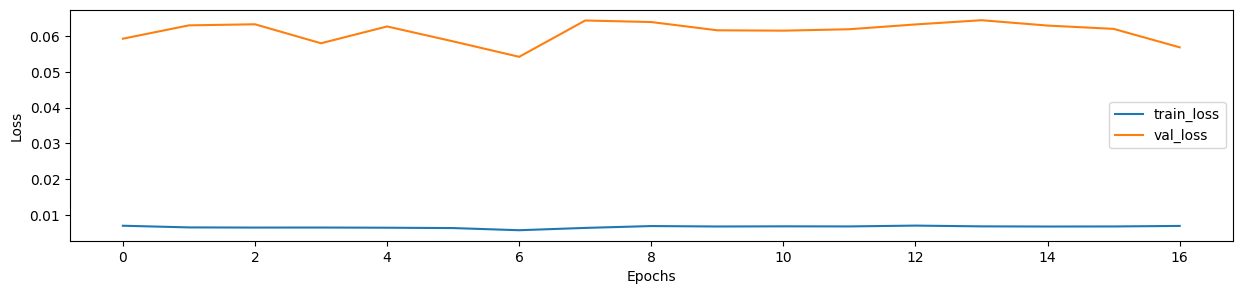

50/50 [==============================] - 0s 2ms/step


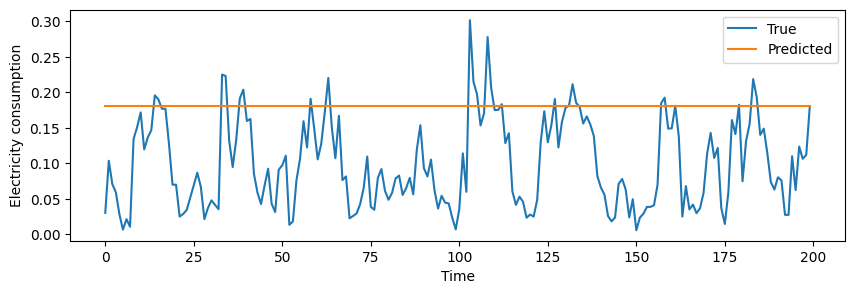

,model,hyperparameters,avg_num_eppochs,avg_train_time_epoch,avg_total_train_time,avg_test_rmse,avg_test_mae
0,top1_moe,,17,1.746588,29.858053,0.155788,0.114993


In [ ]:
"""#top_1_moe_model
sequenze_length = 48
expert_dim = 4
batch_size = 16
dense_1_units = 4
dense_2_units = 2
dense_3_units = 2

top1_moe_model = m1.build_top1_moe_model(X_train, batch_size, horizon, sequenze_length, num_experts, expert_capacity, expert_dim, dense_1_units, dense_2_units, dense_3_units, m1)
moetop1_model_history,moetop1_results, moetop1_summary  = mh.compile_fit_evaluate_model(top1_moe_model, loss, metrics, X_train, y_train, max_epochs, batch_size, X_val, y_val, X_test, y_test, callbacks)
mh.plot_model_predictions(top1_moe_model, moetop1_model_history, y_test, X_test, batch_size, plt_length=200)
moetop1_summary"""